**File:** MLPStock.ipynb

**Mark Oliver
**Adapted from the LinkedIn Course: Data Science Foundations: Data Mining in Python file MLP.ipynb and from
**https://medium.com/@Matthew_Frank/stock-price-prediction-using-transformers-2d84341ff213
**file StockPricePredictionUsingTransformers.ipynb
**https://colab.research.google.com/drive/1j3AYSIxhiNJSCP692pKPbLk4_-kG4Pmh?usp=sharing

# IMPORT LIBRARIES

In [ ]:
%pip install yfinance

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
# import itertools
# from itertools import product

In [2]:
def calculate_bollinger_bands(data, window=35, num_of_std=2):
    """Calculate Bollinger Bands"""
    rolling_mean = data.rolling(window=window).mean()
    rolling_std = data.rolling(window=window).std()
    # print(f'rolling_mean {rolling_mean}   rolling_str {rolling_std}')
    upper_band = rolling_mean + (rolling_std * num_of_std)
    lower_band = rolling_mean - (rolling_std * num_of_std)
    return upper_band, lower_band

def calculate_rsi(data, window=35):
    """Calculate Relative Strength Index"""
    delta = data.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_roc(data, periods=35):
    """Calculate Rate of Change."""
    roc = ((data - data.shift(periods)) / data.shift(periods)) * 100
    return roc

In [3]:
tickers = ["AAPL", "MSFT", "AMZN", "NVDA", "TSLA", "GOOG", "GOOGL",  "BRK-B","META",\
          "UNH", "V", "XOM", "JPM", "JNJ", "WMT", "MA", "PG", "CVX", "HD", "LLY", "ABBV", \
         "BAC", "MRK", "AVGO", "KO", "ORCL", "PEP", "PFE", "TMO", "COST", "QQQ", "CRWD", "TTD"]

In [4]:
print(len(tickers))

33


In [ ]:
yf.Ticker('BRK_B')

In [ ]:
tdata = yf.download("BRK-B", period="1mo", interval="2m")

In [ ]:
tdata.shape

In [ ]:
tdata.head()

In [ ]:
ticker_data_frames = []
stats = {}
for ticker in tickers:

    # Download historical data for the ticker
    data = yf.download(ticker, period="1mo", interval="2m")

    # Calculate the daily percentage change
    close = data['Close']
    upper, lower = calculate_bollinger_bands(close, window=14, num_of_std=2)
    width = upper - lower
    rsi = calculate_rsi(close, window=14)
    roc = calculate_roc(close, periods=14)
    volume = data['Volume']
    diff = data['Close'].diff(1)
    percent_change_close = data['Close'].pct_change() * 100

    # Create a DataFrame for the current ticker and append it to the list
    ticker_df = pd.DataFrame({
        ticker+'_close': close,
        ticker+'_width': width,
        ticker+'_rsi': rsi,
        ticker+'_roc': roc,
        ticker+'_volume': volume,
        ticker+'_diff': diff,
        ticker+'_percent_change_close': percent_change_close
    })

    MEAN = ticker_df.mean()
    STD = ticker_df.std()

    # Keep track of mean and std
    for column in MEAN.index:
      stats[f"{column}_mean"] = MEAN[column]
      stats[f"{column}_std"] = STD[column]

    # Normalize the training features
    ticker_df = (ticker_df - MEAN) / STD

    ticker_data_frames.append(ticker_df)

In [82]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
import pytz
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Convert stats from dict to df
stats = pd.DataFrame([stats], index=[0])
stats.head()

In [6]:
# Concatenate all ticker DataFrames
df = pd.concat(ticker_data_frames, axis=1)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
print(df.shape)
ticker_data_frames[0].head()


NameError: name 'ticker_data_frames' is not defined

In [ ]:
df.tail()

# PLOT DATA

In [ ]:
ticker_data_frames[0].head()

In [ ]:
ticker_data_frames[0]['AAPL_close'].head()

In [ ]:
ticker_data_frames[0].shape

In [ ]:
stats = pd.DataFrame([stats], index=[0])
stats.head()

In [ ]:
stats.shape

In [ ]:
for i, df in enumerate(ticker_data_frames):
    minutes = df.index.strftime("%m%d%M")
    closes = df[f'{tickers[i]}_close'].values
    dft = pd.DataFrame({'y':closes,'x':minutes})
    # df.plot(x=minutes,y=tickers[i]+'_close')
    # dft = dft.reset_index()
    dft.plot('x','y',title=tickers[i])
    # print(df[f'{tickers[i]}_close'].values.size)
    # print(minutes.values.size)
    # print(dft.head())
    # print(minutes.values)

In [ ]:
ticker_data_frames = []
stats = {}
ticker_mean = []
ticker_std = []
time = None
for ticker in tickers:

    # Download historical data for the ticker
    data = yf.download(ticker, period="1mo", interval="2m", timeout=50, repair=True)

    # Calculate the daily percentage change

    close = data['Close']
    upper, lower = calculate_bollinger_bands(close, window=35, num_of_std=2)
    # print(f'upper {upper}   lower {lower}')
    width = upper - lower
    rsi = calculate_rsi(close, window=35)
    roc = calculate_roc(close, periods=35)
    volume = data['Volume']
    diff = data['Close'].diff(1)
    percent_change_close = data['Close'].pct_change() * 100
    percent_change_close = percent_change_close.values.reshape(-1)
    if time is None:
        time = data.index

    # Create a DataFrame for the current ticker and append it to the list
    ticker_df = pd.DataFrame({
        ticker+'_close': close.values.reshape(-1),
        ticker+'_width': width.values.reshape(-1),
        ticker+'_rsi': rsi.values.reshape(-1),
        ticker+'_roc': roc.values.reshape(-1),
        ticker+'_volume': volume.values.reshape(-1),
        ticker+'_diff': diff.values.reshape(-1),
        ticker+'_percent_change_close': percent_change_close,
    })

    MEAN = ticker_df.mean()
    STD = ticker_df.std()

    # Keep track of mean and std
    for column in MEAN.index:
      stats[f"{column}_mean"] = MEAN[column]
      stats[f"{column}_std"] = STD[column]

    # Normalize the training features
    # ticker_df = (ticker_df - MEAN) / STD
    ticker_mean.append(MEAN)
    ticker_std.append(STD)

    ticker_data_frames.append(ticker_df)

In [ ]:
ticker_data_frames[0].head(50)

In [11]:
local_timezone = pytz.timezone('America/New_York') # Replace with your local timezone
local_time = time.tz_convert(local_timezone)
date = time[0].date()
dates_ = [date]
for t in local_time:
    if t.date() != date:
        dates_.append(t.date())
        date = t.date()
dates = np.array(dates_)        
test = np.arange(dates[len(dates)-5], dates[len(dates)-1])
test    

array(['2024-11-18', '2024-11-19', '2024-11-20', '2024-11-21'],
      dtype='datetime64[D]')

In [12]:
stats = pd.DataFrame([stats], index=[0])
stats.head()

,AAPL_close_mean,AAPL_close_std,AAPL_width_mean,AAPL_width_std,AAPL_rsi_mean,AAPL_rsi_std,AAPL_roc_mean,AAPL_roc_std,AAPL_volume_mean,AAPL_volume_std,...,TTD_rsi_mean,TTD_rsi_std,TTD_roc_mean,TTD_roc_std,TTD_volume_mean,TTD_volume_std,TTD_diff_mean,TTD_diff_std,TTD_percent_change_close_mean,TTD_percent_change_close_std
0,227.535251,3.525915,3.624186,2.808643,50.308149,11.186646,-0.01659,0.469271,160180.555655,234916.920335,...,51.155039,11.863908,0.075735,1.301979,18887.642714,29907.560394,0.002624,0.30361,0.002413,0.237143


In [13]:
def mlp_model(X, Y):

    max_iter = 30000
    
    estimator=MLPRegressor(max_iter=max_iter, n_iter_no_change=200)

    params = np.arange(10,65,1)
    jls = [(p,2*p,p) for p in params]
    param_grid = {'hidden_layer_sizes': jls,
          'activation': ['relu','tanh','logistic'],
          'alpha': [0.001, 0.0001, 0.05],
          'learning_rate': ['constant','adaptive'],
          'solver': ['adam'],
           'batch_size':[16,32,64],
            'shuffle': [False]
                 }

    gsc = GridSearchCV(
    estimator,
    param_grid,
    cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

    grid_result = gsc.fit(X, Y)


    best_params = grid_result.best_params_

    best_mlp = MLPRegressor(hidden_layer_sizes = best_params["hidden_layer_sizes"],
                        activation =best_params["activation"],
                        solver=best_params["solver"],
                        max_iter= max_iter, n_iter_no_change = 200
              )

    scoring = {
           'abs_error': 'neg_mean_absolute_error',
           'squared_error': 'neg_mean_squared_error',
           'r2':'r2'}

    scores = cross_validate(best_mlp, X, Y, cv=10, scoring=scoring, return_train_score=True, return_estimator = True)
    return best_params, scores


In [14]:
def mlp_model_short(X, Y):

    max_iter = 30000
    
    estimator=MLPRegressor(max_iter=max_iter, n_iter_no_change=200)

    params = np.arange(49,51,1)
    jls = [(p,2*p,p) for p in params]
    param_grid = {'hidden_layer_sizes': jls,
          'activation': ['relu'],
          'alpha': [0.0001],
          'learning_rate': ['adaptive'],
          'solver': ['adam'],
           'batch_size':[16],
            'shuffle': [False]
                 }

    gsc = GridSearchCV(
    estimator,
    param_grid,
    cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

    grid_result = gsc.fit(X, Y)


    best_params = grid_result.best_params_

    best_mlp = MLPRegressor(hidden_layer_sizes = best_params["hidden_layer_sizes"],
                        activation =best_params["activation"],
                        solver=best_params["solver"],
                        max_iter= max_iter, n_iter_no_change = 200
              )

    scoring = {
           'abs_error': 'neg_mean_absolute_error',
           'squared_error': 'neg_mean_squared_error',
           'r2':'r2'}

    scores = cross_validate(best_mlp, X, Y, cv=10, scoring=scoring, return_train_score=True, return_estimator = True)
    return best_params, scores


- Use the mean squared error (MSE) as cross-validation loss.

In [ ]:
def cross_validation_loss(hidden_neurons, Xtrain, ytrain):

    mse = []

    for train_split_, valid_split_ in tscv.split(Xtrain):

        X_train_, y_train_ = X_train[train_split_], ytrain[train_split_]
        X_valid_, y_valid_ = X_train[valid_split_], ytrain[valid_split_]

        mlp = MLPRegressor(hidden_layer_sizes=(2*hidden_neurons,hidden_neurons, hidden_neurons,), max_iter=5000,
                           activation='relu', optimizer='RMSProp', learning_rate_init=0.001, alpha=0.00001, random_state=1, shuffle=False)

        mlp.fit(X_train_, y_train_)

        mse.append(mean_squared_error(y_valid_, mlp.predict(X_valid_)))

    return np.mean(mse)

In [ ]:
for i,odf in enumerate(ticker_data_frames):
    name = odf.columns.to_list()[0]
    print(f'name: {name}')
    print(stats.columns.to_list()[0])
    print(stats.at[0, name+'_mean'])
    print(stats.at[0, name+'_std'])

ticker_data_frames[0].head(50)

In [86]:
scores = []
params_ = []

In [ ]:
k = 5
total_mse = 0

for i,odf in enumerate(ticker_data_frames):
    # mean_close = ticker_mean[i]
    # mean_std = ticker_std[i]
    # odf = (odf + mean_close) * mean_std
    columns = list(odf.columns.values)
    newColumns = columns[1:k]
    newColumns.append(columns[0])
    df = odf[newColumns]
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    df = df.iloc[:-1]
    # print(df.head())
    Z = df.to_numpy()
    split = np.int32(0.8 * Z.shape[0])
    Z_train, Z_test = Z[:split, :], Z[split:, :]
    scaler = StandardScaler().fit(Z_train)
    Z_train = scaler.transform(Z_train)
    Z_test = scaler.transform(Z_test)
    X_train, y_train = Z_train[:, :-1], Z_train[:, -1]
    X_test, y_test = Z_test[:, :-1], Z_test[:, -1]
    params, score= mlp_model(X_train, y_train)
    params_.append(params)
    scores.append(score)
    # score=scores[0]
    # params=params_[0]
    y_pred = None
    for i_,e in enumerate(score['estimator']):
        e.fit(X_train, y_train)
        pred = e.predict(X_test)
        if i_ == 0:
            y_pred = np.array(pred)
        else:
            y_pred += np.array(pred)    
    y_pred /= len(score['estimator'])

        
    # mlp = MLPRegressor(hidden_layer_sizes = params["hidden_layer_sizes"],
    #                 activation =params["activation"],
    #                 solver=params["solver"],
    #                 max_iter= 5000, n_iter_no_change = 200

    # params = [10,15, 16, 17, 18, 19 ,20,21,22,23,24,25,30,35,40,45,50,55,60,65,75]
    # params = np.arange(10,25,1)
    # mse = [cross_validation_loss(p, X_train,y_train) for p in params]
    # minMSE = params[np.argmin(mse)]
    # mlp = MLPRegressor(hidden_layer_sizes=(2*minMSE,minMSE,minMSE,), max_iter=5000, random_state=1,
    #                    activation='relu', learning_rate_init=0.001, alpha=0.00001,shuffle=False)
    # print(f'minMSE: {minMSE}  df.shape {df.shape} {stats.iloc[0][0:2]} {stats.iloc[0][0]}    {stats.iloc[0][1]}')
    # close = odf.columns.to_list()[0]
    # mlp.fit(X_train, y_train)
    # y_pred = mlp.predict(X_test)
    y_test_ = (scaler.inverse_transform(np.hstack([X_test, y_test.reshape(-1, 1)]))[:, -1])
    y_pred_ = (scaler.inverse_transform(np.hstack([X_test, y_pred.reshape(-1, 1)]))[:, -1])
    mse_ = mean_squared_error(y_test_, y_pred_)
    total_mse += mse_
    print(f'mean squared error {mse_}')
    fig, ax = plt.subplots()
    plt.xlabel(tickers[i])
    plt.ylabel(f'{tickers[i]} close')
    plt.title(f'2 minute {tickers[i]}')
    time = mdates.drange(dates[len(dates)-np.round(len(y_test_)/180).astype(int)],dates[len(dates)-1],  dt.timedelta(days=1))
    fractions = np.linspace(min(time), max(time), len(y_test_))
    plt.plot(fractions, pd.Series(y_test_), color='blue', label=f'{tickers[i]} Test Data')
    plt.plot(fractions, pd.Series(y_pred_), color='red', label=f'Forecast {tickers[i]}')
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d-%y"))
    plt.xlim(min(time), max(time))
    plt.xticks(time)
    ax.xaxis_date() # Default date formatter
    fig.autofmt_xdate()
    plt.legend(loc='upper right') 
    plt.show()    
    # break
print(total_mse)

In [37]:
import matplotlib.dates as mdates
import datetime as dt

In [73]:
import importlib
importlib.reload(plt)

<module 'matplotlib.pyplot' from '/home/mark/anaconda3/envs/MLPstock/lib/python3.12/site-packages/matplotlib/pyplot.py'>

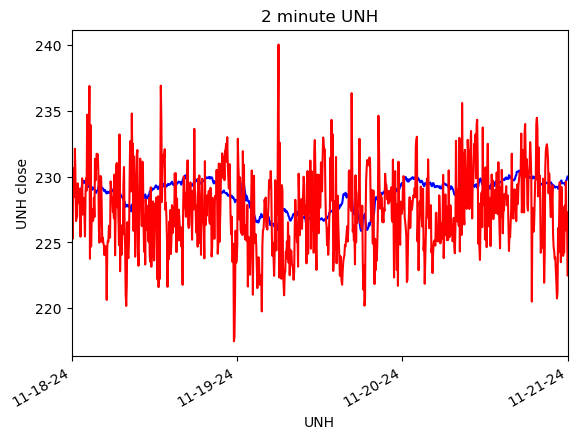

In [85]:
    fig, ax = plt.subplots()
    plt.xlabel(tickers[i])
    plt.ylabel(f'{tickers[i]} close')
    plt.title(f'2 minute {tickers[i]}')
    time = mdates.drange(dates[len(dates)-np.round(len(y_test_)/180).astype(int)],dates[len(dates)-1],  dt.timedelta(days=1))
    fractions = np.linspace(min(time), max(time), len(y_test_))
    plt.plot(fractions, pd.Series(y_test_), color='blue', label='Test Data')
    plt.plot(fractions, pd.Series(y_pred_), color='red', label=f'Forecast {tickers[i]}')
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d-%y"))
    m = min(time);
    plt.xlim(min(time), max(time))
    plt.xticks(time)
    ax.xaxis_date() # Default date formatter
    fig.autofmt_xdate()
    plt.show()


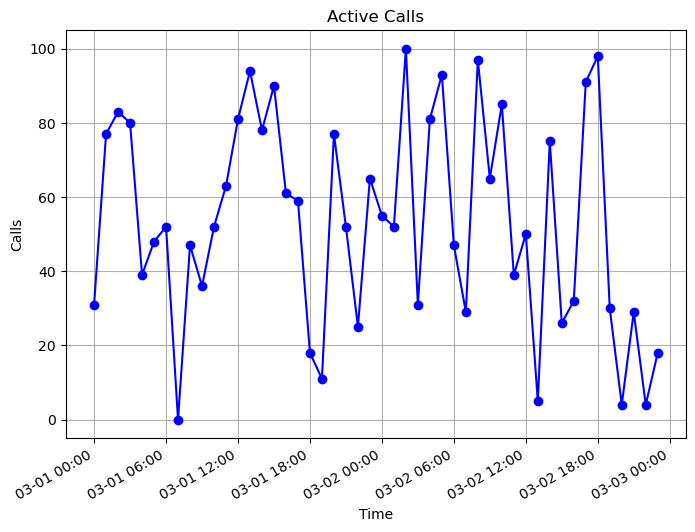

In [64]:
import random
 
x = mdates.drange(dt.datetime(2021, 3, 1, 0, 0, 0), dt.datetime(2021, 3, 3, 0, 0, 0),
                     dt.timedelta(hours=1))
y = [random.randint(0,100) for _ in range(len(x))]
time = mdates.drange(dt.datetime(2021, 3, 1, 0, 0, 0), dt.datetime(2021, 3, 3, 1, 0, 0),
                     dt.timedelta(hours=6))
  
fig, ax = plt.subplots(figsize=(8, 6))
plt.xticks(time)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d %H:%M"))
# ax.xaxis.set_minor_formatter(mdates.DateFormatter("%m-%d %H:%M"))
ax.plot(x, y, 'bo-')
ax.set(title='Active Calls', ylabel='Calls', xlabel='Time')
ax.grid()
  
ax.xaxis_date() # Default date formatter
fig.autofmt_xdate()
  
plt.show()

- Calculate the cross validation loss corresponding to different numbers of hidden nodes.

In [ ]:
params = [10,15,20,25,30,35,40,45,50,55,60,65,75]
mse = [cross_validation_loss(p) for p in params]

In [ ]:
fig, ax = plt.subplots()
plt.xlabel('Hidden Nodes')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('5-Fold Cross Validation Loss')
plt.plot(params, mse, '-o')

- Find the number of hidden nodes associated with the smallest cross validation loss.

In [ ]:
params[np.argmin(mse)]

In [ ]:
y_train

- Fit an MLP model with 50 hidden nodes to the training data.

In [ ]:
mlp = MLPRegressor(hidden_layer_sizes=(50,), max_iter=500, random_state=1, shuffle=False)

In [ ]:
mlp.fit(X_train, y_train)

- Use the fitted MLP model to forecast the test data.

In [ ]:
y_pred = mlp.predict(X_test)

- Transform the data back to the original scale.

In [ ]:
y_test_ = scaler.inverse_transform(np.hstack([X_test, y_test.reshape(-1, 1)]))[:, -1]
y_pred_ = scaler.inverse_transform(np.hstack([X_test, y_pred.reshape(-1, 1)]))[:, -1]

- Plot the data and the forecasts in the original scale.

In [ ]:
fig, ax = plt.subplots()
plt.xlabel('Year: 1949-1960')
plt.ylabel('Monthly Passengers (1000s)')
plt.title('Monthly Intl Air Passengers')
plt.plot(df.iloc[:(k + len(y_train) + 1), :], color='black', label='Training Data')
plt.plot(pd.Series(y_test_, index=df.index[-len(y_test):]), color='blue', label='Test Data')
plt.plot(pd.Series(y_pred_, index=df.index[-len(y_test):]), color='red', label='Forecast (50 hidden nodes)')
plt.legend(bbox_to_anchor=(1.05, 1))
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

# CLEAN UP

- If desired, clear the results with Cell > All Output > Clear.
- Save your work by selecting File > Save and Checkpoint.
- Shut down the Python kernel and close the file by selecting File > Close and Halt.